## Code to reproduce Figure S1

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import os
import pickle
import cftime
import matplotlib.dates as mdates

In [12]:
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['legend.edgecolor']='black'
plt.rcParams['axes.linewidth']='0.8'
plt.rcParams['xtick.bottom']= 'True'
plt.rcParams['ytick.left']= 'True'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['xtick.major.size']='3.5'
plt.rcParams['ytick.major.size']='3.5'
plt.rcParams['xtick.major.width']='0.8'
plt.rcParams['ytick.major.width']='0.8'

plt.rc('font', size=14) # controls default text sizes          
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

In [3]:
## Functions

def calc_max_min(da1, da2, da3):

    concat_da = xr.concat([da1, da2, da3], dim='concat_dim')
    concat_da = concat_da.resample(time='YE').mean(dim='time')

    df_mean = concat_da.mean(dim='concat_dim')

    df_max = concat_da.max(dim='concat_dim')

    df_min = concat_da.min(dim='concat_dim')
    
    return df_mean, df_max, df_min

def calc_3yr_moving_mean(df_annual):
    data = df_annual.rolling(time=3, center=True).mean()
    return data

def calc_30yr_moving_mean(df_annual):
    data = df_annual.rolling(time=30, center=True).mean()
    return data

def calc_mean_max_min(df):
    
    df_mean = df.mean(dim='ensemble')
    df_max = df.max(dim='ensemble')
    df_min = df.min(dim='ensemble')
    
    return df_mean, df_max, df_min
    
def plot_ozone_deficit(ax, df, df_max, df_min):

    lighlbl = '#C7E9FF'
    ax.plot(year_axis, df['volc25'].ozone_deficit, color = 'navy', ls = 'dashdot', label = 'VOLC2.5', linewidth = 2)
    ax.plot(year_axis, df['volc50_1'].ozone_deficit, color = 'navy', ls = 'solid', label = 'VOLC50-1', linewidth = 2)
    ax.plot(year_axis, df['volc50_2'].ozone_deficit, color = 'navy', ls = 'dashed', label = 'VOLC50-2', linewidth = 2)
    ax.plot(year_axis, df['volc98'].ozone_deficit, color = 'navy', ls = 'dotted', label = 'VOLC98', linewidth = 2)
    ax.plot(year_axis, df['novolc'].ozone_deficit, color = 'red', label = 'NOVOLC', linewidth = 2.5)
    
    
    ax.fill_between(year_axis, df['volc98'].ozone_deficit, df_max['volc98'].ozone_deficit, color = lighlbl)
    ax.fill_between(year_axis, df['volc98'].ozone_deficit, df_min['volc98'].ozone_deficit, color = lighlbl)
    ax.fill_between(year_axis, df['volc50_1'].ozone_deficit, df_max['volc50_1'].ozone_deficit, color = lighlbl)
    ax.fill_between(year_axis, df['volc50_1'].ozone_deficit, df_min['volc50_1'].ozone_deficit, color = lighlbl)
    ax.fill_between(year_axis, df['volc50_2'].ozone_deficit, df_max['volc50_2'].ozone_deficit, color = lighlbl)
    ax.fill_between(year_axis, df['volc50_2'].ozone_deficit, df_min['volc50_2'].ozone_deficit, color = lighlbl)
    ax.fill_between(year_axis, df['volc25'].ozone_deficit, df_max['volc25'].ozone_deficit, color = lighlbl)
    ax.fill_between(year_axis, df['volc25'].ozone_deficit, df_min['volc25'].ozone_deficit, color = lighlbl)
    ax.fill_between(year_axis, df['novolc'].ozone_deficit, df_max['novolc'].ozone_deficit, color = 'pink', alpha = 0.3)
    ax.fill_between(year_axis, df['novolc'].ozone_deficit, df_min['novolc'].ozone_deficit, color = 'pink', alpha = 0.3)

    return ax

def calc_toc_SH(df):
    
    def is_oct(month):
        return (month == 10)
  
    temp = df.m01s50i219[:,:,24:48,:]
    weights = np.cos(np.deg2rad(temp.latitude[0:24]))
    weights.name = "weights"
    temp_w = temp.weighted(weights)
    toc_sum = temp_w.mean(dim=['latitude','longitude'])

    toc = toc_sum.sel(time=is_oct(toc_sum['time.month']))
    #toc = toc.resample(time='YE').mean(dim='time')
    
    return toc

def calc_toc_NH(df):
  
    temp = df.m01s50i219[:,:,96:120,:]
    weights = np.cos(np.deg2rad(temp.latitude[0:24]))
    weights.name = "weights"
    temp_w = temp.weighted(weights)
    toc_sum = temp_w.mean(dim=['latitude','longitude'])
    toc = toc_sum.resample(time='YE').mean(dim='time')
    
    return toc

def calc_toc_global(df):
  
    temp = df.m01s50i219
    weights = np.cos(np.deg2rad(temp.latitude))
    weights.name = "weights"
    temp_w = temp.weighted(weights)
    toc_sum = temp_w.mean(dim=['latitude','longitude'])
    toc = toc_sum.resample(time='YE').mean(dim='time')
    
    return toc


def plot_tco(ax,df,df_max,df_min):
    ax.plot(year_axis, df['volc50_1'], color = 'navy', ls = 'solid', label = 'VOLC50-1', linewidth = 2)
    ax.plot(year_axis, df['volc50_2'], color = 'navy', ls = 'dashed', label = 'VOLC50-2', linewidth = 2)
    ax.plot(year_axis, df['volc25'], color = 'navy', ls = 'dashdot', label = 'VOLC2.5', linewidth = 2)
    ax.plot(year_axis, df['volc98'], color = 'navy', ls = 'dotted', label = 'VOLC98', linewidth = 2)
    ax.plot(year_axis, df['novolc'], color = 'red', ls = 'solid', label = 'NOVOLC', linewidth = 2.5)

    lighlbl = '#C7E9FF'

    ax.fill_between(year_axis, df['volc98'], df_max['volc98'], color = lighlbl)
    ax.fill_between(year_axis, df['volc50_1'], df_max['volc50_1'], color = lighlbl)
    ax.fill_between(year_axis, df['volc50_1'] , df_min['volc50_1'], color = lighlbl)
    ax.fill_between(year_axis, df['volc50_2'], df_max['volc50_2'], color = lighlbl)
    ax.fill_between(year_axis, df['volc50_2'] , df_min['volc50_2'], color = lighlbl)
    ax.fill_between(year_axis, df['volc25'], df_max['volc25'], color = lighlbl)
    ax.fill_between(year_axis, df['volc25'] , df_min['volc25'], color = lighlbl)
    ax.fill_between(year_axis, df['novolc'], df_max['novolc'], color = 'pink', alpha = 0.2)
    ax.fill_between(year_axis, df['novolc'] , df_min['novolc'], color = 'pink', alpha = 0.2)

    return ax    

## Plot Figure S1

In [4]:
novolc = ['cj313','cj314','cj315']
volc50_1 = ['cj348','cj349','cj350']
volc50_2 = ['ck531','ck532','ck533']
volc98 = ['cn754','cn755','cn756']
volc25 = ['co565','co566','co567']

In [13]:
os.chdir('/gws/nopw/j04/vplume/mchim/netcdf_files/Ozone_daily/Ozone_processed/ozone_deficit/')

location = 'SH'
ozonelev = '220'
path = location+'_'+ozonelev+'/'

ssp370_run = {'novolc': novolc,
              'volc50_1': volc50_1,
              'volc50_2': volc50_2,
              'volc98': volc98,
              'volc25': volc25}

for idx in ssp370_run:
    
    suite_id = ssp370_run[idx]
    filename = []
    dict_ens = {}
    
    for i, id in enumerate(suite_id):

        filename = id+'_daily_ozone_deficit_'+ozonelev+'DU.nc'
        
        df = xr.open_dataset(path+filename)
        df.attrs.pop('history', None)
        df.attrs['history'] = ''
        
        # output only the monthly mean
        time_temp = xr.open_dataset(path+'cj313_daily_ozone_deficit_'+ozonelev+'DU.nc').time
        df['time'] = time_temp
        dict_ens[i]=df.resample(time='1ME').mean()
       
    ssp370_run[idx] = dict_ens

SH_3year_mean = {}
SH_3year_max = {}
SH_3year_min = {}

for idx in ssp370_run:
    df = ssp370_run[idx]

    SH_3year_ens1 = calc_30yr_moving_mean(ssp370_run[idx][0].sel(time=ssp370_run[idx][0]['time.month']==10))
    SH_3year_ens2 = calc_30yr_moving_mean(ssp370_run[idx][1].sel(time=ssp370_run[idx][1]['time.month']==10))
    SH_3year_ens3 = calc_30yr_moving_mean(ssp370_run[idx][2].sel(time=ssp370_run[idx][2]['time.month']==10))
    SH_3year_mean[idx], SH_3year_max[idx], SH_3year_min[idx] = calc_max_min(SH_3year_ens1,SH_3year_ens2,SH_3year_ens3)


In [14]:
os.chdir('/gws/nopw/j04/vplume/mchim/netcdf_files/Ozone_daily/Ozone_processed/ozone_deficit/')

location = 'NH'
ozonelev = '220'
path = location+'_'+ozonelev+'/'

ssp370_run = {'novolc': novolc,
              'volc50_1': volc50_1,
              'volc50_2': volc50_2,
              'volc98': volc98,
              'volc25': volc25}

for idx in ssp370_run:
    
    suite_id = ssp370_run[idx]
    filename = []
    dict_ens = {}
    
    for i, id in enumerate(suite_id):

        filename = id+'_daily_ozone_deficit_'+ozonelev+'DU.nc'
        
        df = xr.open_dataset(path+filename)
        df.attrs.pop('history', None)
        df.attrs['history'] = ''
        
        # output only the monthly mean
        time_temp = xr.open_dataset(path+'cj313_daily_ozone_deficit_'+ozonelev+'DU.nc').time
        df['time'] = time_temp
        dict_ens[i]=df.resample(time='1ME').mean()
       
    ssp370_run[idx] = dict_ens

NH_3year_mean = {}
NH_3year_max = {}
NH_3year_min = {}

for idx in ssp370_run:
    df = ssp370_run[idx]
 
    NH_3year_ens1 = calc_3yr_moving_mean(ssp370_run[idx][0])
    NH_3year_ens2 = calc_3yr_moving_mean(ssp370_run[idx][1])
    NH_3year_ens3 = calc_3yr_moving_mean(ssp370_run[idx][2])
    NH_3year_mean[idx], NH_3year_max[idx], NH_3year_min[idx] = calc_max_min(NH_3year_ens1,NH_3year_ens2,NH_3year_ens3)


In [15]:
os.chdir('/gws/nopw/j04/vplume/mchim/netcdf_files/ozone_all_levs_monthly/')

novolc = ['cj313','cj314','cj315']
volc50_1 = ['cj348','cj349','cj350']
volc50_2 = ['ck531','ck532','ck533']
volc98 = ['cn754','cn755','cn756']
volc25 = ['co565','co566','co567']

ssp370_run = {'novolc': novolc,
              'volc50_1': volc50_1,
              'volc50_2': volc50_2,
              'volc98': volc98,
              'volc25': volc25}

for idx in ssp370_run:
    
    suite_id = ssp370_run[idx]
    
    # read model level 1 only
    ds_list = [xr.open_dataset(f'u-{id}_monthly_volc_ozone.nc').sel({'model_level_number': 1}) 
               if 'model_level_number' in xr.open_dataset(f'u-{id}_monthly_volc_ozone.nc').dims 
               else xr.open_dataset(f'u-{id}_monthly_volc_ozone.nc') for id in suite_id]
            
    ssp370_run[idx] = xr.concat(ds_list, dim='ensemble')

In [16]:
df_global = {'mean': {}, 'max': {}, 'min': {},'ens1':{}, 'ens2':{}, 'ens3':{}}

for idx in ssp370_run:
    for i in range(len(ssp370_run[idx])):
        temp_global = calc_toc_global(ssp370_run[idx])
        
        temp = calc_30yr_moving_mean(temp_global)
        df_global['mean'][idx], df_global['max'][idx], df_global['min'][idx] = calc_mean_max_min(temp) 
        df_global['ens1'][idx] = calc_30yr_moving_mean(temp_global[0])
        df_global['ens2'][idx] = calc_30yr_moving_mean(temp_global[1])
        df_global['ens3'][idx] = calc_30yr_moving_mean(temp_global[2])

In [17]:
df_SH_TOC = {'mean':{},'max': {}, 'min': {}, 'ens1':{}, 'ens2':{}, 'ens3':{}}
df_NH_TOC = {'mean':{},'max': {}, 'min': {}, 'ens1':{}, 'ens2':{}, 'ens3':{}}

for idx in ssp370_run:
    for i in range(len(ssp370_run[idx])):        
        annual_SH = calc_toc_SH(ssp370_run[idx])
        temp = calc_30yr_moving_mean(annual_SH)
        df_SH_TOC['mean'][idx], df_SH_TOC['max'][idx], df_SH_TOC['min'][idx] = calc_mean_max_min(temp) 
        df_SH_TOC['ens1'][idx] = calc_30yr_moving_mean(annual_SH[0])
        df_SH_TOC['ens2'][idx] = calc_30yr_moving_mean(annual_SH[1])
        df_SH_TOC['ens3'][idx] = calc_30yr_moving_mean(annual_SH[2])

        annual_NH = calc_toc_NH(ssp370_run[idx])
        temp2 = calc_30yr_moving_mean(annual_NH)
        df_NH_TOC['mean'][idx], df_NH_TOC['max'][idx], df_NH_TOC['min'][idx] = calc_mean_max_min(temp2) 
        df_NH_TOC['ens1'][idx] = calc_30yr_moving_mean(annual_NH[0])
        df_NH_TOC['ens2'][idx] = calc_30yr_moving_mean(annual_NH[1])
        df_NH_TOC['ens3'][idx] = calc_30yr_moving_mean(annual_NH[2])

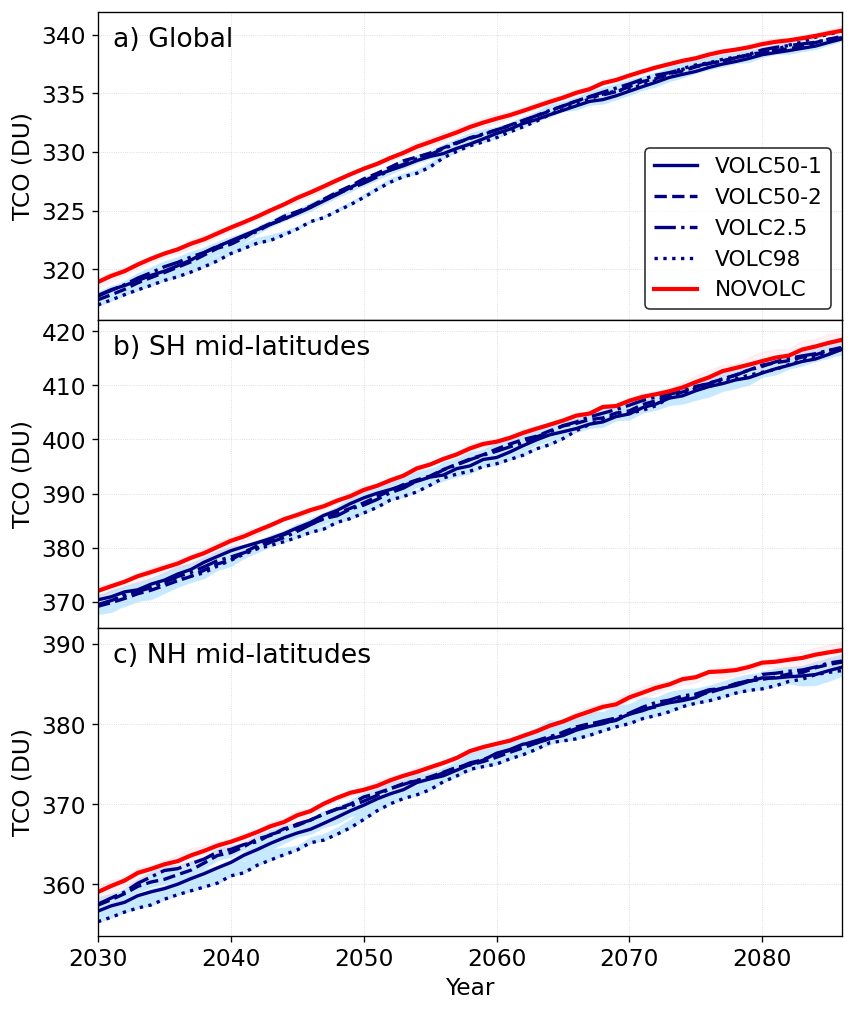

In [19]:
fig, axs = plt.subplots(3, 1, figsize=(8,10), dpi=120)
plt.subplots_adjust(hspace=0, wspace = 0)
ax1, ax2, ax3 = axs.flatten()
year_axis = np.arange(2015,2101,1)
daysince = cftime.date2num(SH_3year_mean['volc50_1'].time, 'days since 2015-01-01', '360_day')

# Plot data
plot_tco(ax1, df_global['mean'], df_global['max'], df_global['min'])
plot_tco(ax2, df_SH_TOC['mean'], df_SH_TOC['max'], df_SH_TOC['min'])
plot_tco(ax3, df_NH_TOC['mean'], df_NH_TOC['max'], df_NH_TOC['min'])

# Set common properties for all axes
for ax in (ax1, ax2, ax3):
    ax.set_ylabel('TCO (DU)')
    ax.set_xlabel('Year')
    ax.set_xlim(2030,2086)
    ax.grid(color='lightgrey', which = 'both', linestyle='dotted', linewidth=0.5)

# Add subplot labels and titles in top left corners
ax1.text(0.02, 0.95, 'a) Global', transform=ax1.transAxes, 
         fontsize=16, verticalalignment='top')

ax2.text(0.02, 0.95, 'b) SH mid-latitudes', transform=ax2.transAxes, 
         fontsize=16, verticalalignment='top')

ax3.text(0.02, 0.95, 'c) NH mid-latitudes', transform=ax3.transAxes, 
         fontsize=16, verticalalignment='top')

# Add legend
ax1.legend(fontsize = 13, loc = 'lower right', ncol = 1)

ax1.set_xticklabels([])
ax1.tick_params(axis='x', which='both', bottom=False)
ax2.set_xticklabels([])
ax2.tick_params(axis='x', which='both', bottom=False)
